## Deep Learning: Classifying Astronomical Images 

### January 6, 2020 


[astroML workshop at the 235th Meeting of the American Astronomical Society](http://www.astroml.org/workshops/AAS235.html)

[Andrew Connolly, University of Washington](http://faculty.washington.edu/ajc26/) 

[This notebook](https://github.com/...)


In this notebook we work through a simple example for a Neural Network using TensorFlow and the Keras interface. Initially we will start with a vanila network with two hidden layers and then expand this to a convolutional neural network with drop out layers and batch normalization

Deep learning, an extension of the neural networks that were
popularized in the 1990s. The concepts are inspired
by the structure and function of the brain. A neuron in the brain is a
core computational unit that takes a series of inputs from branched
extensions of the neuron called dendrites, operates on these inputs,
and generates an output that is transmitted along an axon to one or
more other neurons. In the context of a neural network a neuron, $j$, takes a set of inputs,
$x_i$, applies a, typically non-linear, function to these inputs and
generates an output value. Networks are then created by connecting
multiple neurons or layers of neurons to one another.

<img src="figures/fig_neural_network-1.png">

If we consider the simplified network
inputs are passed to the neurons in the
network. Each input is weighted by a value, $w_{ij}$ and the sum of
these weighted inputs is operated on by a response or activation
function $f(\theta)$, which transform
the input signal so that it varies between 0 and 1 through the
application of a non-linear response. The output from any neuron is
then given by,

$$
\begin {equation}
a_j =  f  \left( \sum_i w_{ij} x_i + b_j \right)
\end{equation}
$$

where $b_j$ is a bias term determines the input level at which the
neuron becomes activated.

We refer to the neurons between the inputs and the output layers as
the hidden layers. If the neurons from one layer connect to all
neurons in a subsequent layer we call this a fully connected layer.
When the outputs from the neurons only connect to subsequent layers
(i.e. the graph is acyclic) we refer to this as a feed-forward
network.  In general the feed-forward network is the most common
structure for a neural network used in classification. 

The final layer in the network is the output layer. As with the hidden
layer, an activation function, $g(\theta)$, in the output layer acts
on the weighted sum of its inputs.  In this figure we have a single
output node but there can be multiple outputs. For our example  network the
output from the final neuron, $o_k$, would be given by

$$
\begin {equation}
o_k = g \left( \sum_j   w_{jk} a_j  + b_k \right)  = g\left( \sum_j
  w_{jk}  f \left( \sum_i w_{ij} x_i + b_j\right) + b_k\right)
\end{equation}
$$



In [1]:
# to reduce the deprecation warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
#check we have a GPU available
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12961419463044207280, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14631653085172186503
 physical_device_desc: "device: XLA_CPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11889390388
 locality {
   bus_id: 7
   numa_node: 6
   links {
   }
 }
 incarnation: 14390101942619887567
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:61:00.0, compute capability: 6.0", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17558569787752093834
 physical_device_desc: "device: XLA_GPU device"]

In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from astroML.utils import split_samples
from tensorflow.keras.utils import to_categorical
%matplotlib inline

### Loading some visualization and helper functions

In [82]:
np.set_printoptions(precision=2)

def normalize_image(image):
    '''Rescale a stamp for CNN'''
    sigmaG_coeff =  0.7413
    image = image.reshape(21,21)
    
    per25,per50,per75 = np.percentile(image,[25,50,75])
    sigmaG = sigmaG_coeff * (per75 - per25)
    image[image<(per50-2*sigmaG)] = per50-2*sigmaG
    image -= np.min(image)
    image /= np.sum(image)
    
    return image
    
def plot_image_array(images, nrows=2, ncols=5, figsize=[8,4], nx=21, ny=21, title='', subtitle=''):
    '''Plot an array of images'''
    fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize)
    fig.subplots_adjust(hspace=0, left=0.07, right=0.95, wspace=0.05, bottom=0.15)
    for indx in np.arange(nrows*ncols):
        i = int(indx/ncols)
        j = indx%ncols
        if (i == 0):
            ax[i][j].xaxis.set_major_formatter(plt.NullFormatter())
        if (j != 0):
            ax[i][j].yaxis.set_major_formatter(plt.NullFormatter())

        ax[i][j].imshow(images[indx].reshape(nx,ny), cmap='gray')
        ax[i][j].set_title(subtitle)

    fig.suptitle(title)
    ax[0][0].set_ylabel('$y$')
    ax[nrows-1][int(ncols/2)].set_xlabel('$x$')            
    
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, 
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

def plot_model_history(history):
    '''Plot the training and validation history'''

    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    acc = model_history.history['accuracy']
    val_acc = model_history.history['val_accuracy']
    
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5))
    ax[0].plot(np.arange(n_epochs), loss, label='Training Loss')
    ax[0].plot(np.arange(n_epochs), val_loss, label='Validation Loss')
    ax[0].set_title('Loss Curves')
    ax[0].legend()
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')

    ax[1].plot(np.arange(n_epochs), acc, label='Training Accuracy')
    ax[1].plot(np.arange(n_epochs), val_acc, label='Validation Accuracy')
    ax[1].set_title('Accuracy Curves')
    ax[1].legend()
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')

### Load the training samples and create test and validation data sets

In [5]:
import numpy as np
import matplotlib.pyplot as plt

#read in source and noise images
path = './'
rand_state = np.random.RandomState(777)
sources = np.load(path+'data/stamps_sources.npz')
noise = np.load(path+'data/stamps_noise.npz')

point_source_stamps = []
for image in sources['data']:
    point_source_stamps.append(normalize_image(image))

no_point_source_stamps = []
for image in noise['data']:
    no_point_source_stamps.append(normalize_image(image))

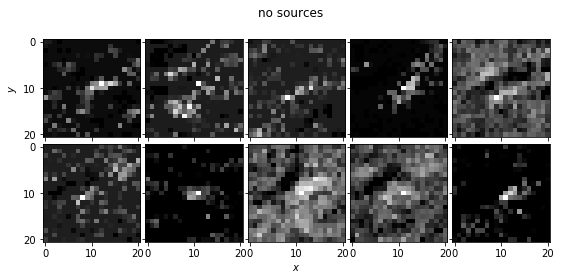

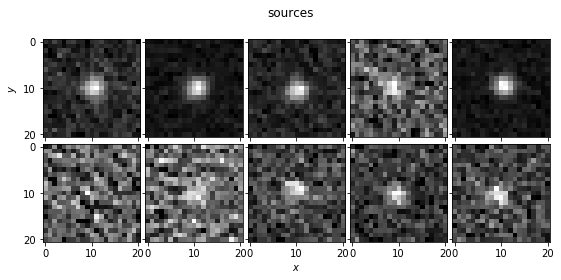

In [83]:
#plot sample of images
plot_image_array(no_point_source_stamps, title='no sources')
plot_image_array(point_source_stamps, title='sources')

### Create a training, validation, and test sample

We will use astroML's split_samples to do this

In [7]:
def reshape_arrays(data, labels):
    '''reshape arrays for Keras'''
    data = data.reshape(-1,21, 21, 1) 
    labels = to_categorical(labels)
    return data,labels

input_stamps = np.vstack([no_point_source_stamps, point_source_stamps])
stamp_class = np.zeros(len(no_point_source_stamps) + len(point_source_stamps))
stamp_class[len(no_point_source_stamps):] = 1

(data_train, data_val, data_test), (class_train, class_val, class_test) = split_samples(input_stamps, stamp_class, 
                                                                                        [0.7,0.2,0.1])
data_train, class_train = reshape_arrays(data_train, class_train)
data_val, class_val = reshape_arrays(data_val, class_val)
data_test, class_test = reshape_arrays(data_test, class_test)

print ('Number of samples in the training ({}); test ({}); and validation ({}) data sets'.format(data_train.shape[0], 
                                                                                    data_test.shape[0],
                                                                                   data_val.shape[0]))

Number of samples in the training (42000); test (6000); and validation (12000) data sets


## Neural Network Frameworks


The development and release of open source deep learning libraries has
made the use of deep neural networks accessible to a wide range of
fields. Currently there are two common packages PyTorch (https://pytorch.org) and Tensorflow (https://www.tensorflow.org). Either code base can be utilized for the
figures and problems in this book (and generally they have the same
functionality). 

### TensorFlow:

Tensorflow is the more established code base with a large community
and a large number of tutorials (https://www.tensorflow.org/tutorials) and online courses. Its
functionality is more developed than PyTorch with tools to visualize
and inspect a network (e.g., see TensorBoard). On the other hand, the
learning curve for PyTorch is generally considered to be easier than
that for Tensorflow with PyTorch having a more natural object oriented
interface for people used to writing Python code.

### PyTorch

The primary difference between TensorFlow and PyTorch is that the
networks (or graphs) that Tensorflow generates are static while the
networks for PyTorch are dynamic. This means that with PyTorch one can
modify and adjust the network on-the-fly (e.g., making it easier to
adjust for changes in the input dimensionality or number of input
nodes within a network). This feature and the object-oriented design of
PyTorch often results in fewer lines of code to achieve the same
solution when compared to Tensorflow.

What should you choose? Both frameworks are continuously evolving
and advances in one (e.g., dynamic networks) are rapidly implemented
in the other. In the end, the choice of deep learning library will
likely come down to which one you find better fits your style of
programming and learning.

### Keras:  

Keras is a high-level API written on top of TensorFlow (and its precursor Theano). It is written in Python and provides a simple and intuative interface when building neural networks. It is currently released as part of TensorFlow and we will using Keras in this tutorial.

## Creating a Neural Network with Keras

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

import numpy as np
def simple(input_shape=(21, 21, 1), n_classes: int = 2):

    model = tf.keras.models.Sequential(name='simple')
    # input: 21x21 images with 1 channel -> (21, 21, 1) tensors.
    # this applies 16 convolution filters of size 3x3 each.
    model.add(tf.keras.layers.Dense(30, input_shape=input_shape, activation='relu', name='fc_1'))
    
    model.add(tf.keras.layers.Dense(30, activation='relu', name='fc_2'))

    model.add(tf.keras.layers.BatchNormalization(axis = 3, name = 'bn_1'))

    model.add(tf.keras.layers.Flatten())
    # output layer
    activation = 'sigmoid' if n_classes == 1 else 'softmax'
    model.add(tf.keras.layers.Dense(n_classes, activation=activation, name='fc_out'))

    return model

In [9]:
simple_model = simple()
simple_model.summary()

Model: "simple"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_1 (Dense)                 (None, 21, 21, 30)        60        
_________________________________________________________________
fc_2 (Dense)                 (None, 21, 21, 30)        930       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 21, 21, 30)        120       
_________________________________________________________________
flatten (Flatten)            (None, 13230)             0         
_________________________________________________________________
fc_out (Dense)               (None, 2)                 26462     
Total params: 27,572
Trainable params: 27,512
Non-trainable params: 60
_________________________________________________________________


In [10]:
simple_model = simple()
n_epochs=5
simple_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
simple_model_history = simple_model.fit(data_train, class_train, epochs=n_epochs, batch_size=1, verbose=1, 
                                        validation_data=(data_val, class_val), shuffle=True)

Train on 42000 samples, validate on 12000 samples
Epoch 1/5
42000/42000 [==============================] - 211s 5ms/sample - loss: 0.1891 - accuracy: 0.9305 - val_loss: 0.2057 - val_accuracy: 0.9341
Epoch 2/5
42000/42000 [==============================] - 209s 5ms/sample - loss: 0.1448 - accuracy: 0.9427 - val_loss: 0.2098 - val_accuracy: 0.9364
Epoch 3/5
42000/42000 [==============================] - 207s 5ms/sample - loss: 0.1373 - accuracy: 0.9454 - val_loss: 0.2306 - val_accuracy: 0.9374
Epoch 4/5
42000/42000 [==============================] - 203s 5ms/sample - loss: 0.1333 - accuracy: 0.9460 - val_loss: 0.2193 - val_accuracy: 0.9366
Epoch 5/5
42000/42000 [==============================] - 197s 5ms/sample - loss: 0.1317 - accuracy: 0.9467 - val_loss: 0.2300 - val_accuracy: 0.9361


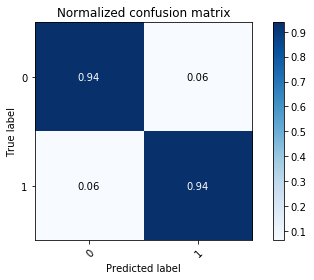

In [53]:
classes = simple_model.predict(data_test)
plot_confusion_matrix(np.argmax(class_test,axis=1), np.argmax(classes,axis=1), normalize=True,
                      title='Normalized confusion matrix')


In [16]:
simple_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
simple_model_history = simple_model.fit(data_train, class_train, epochs=n_epochs, batch_size=256, verbose=1, 
                                        validation_data=(data_val, class_val), shuffle=True)
classes = simple_model.predict(data_test)

Train on 42000 samples, validate on 12000 samples
Epoch 1/5
42000/42000 [==============================] - 3s 80us/step - loss: 0.6841 - acc: 0.7538 - val_loss: 0.6915 - val_acc: 0.5308
Epoch 2/5
42000/42000 [==============================] - 2s 39us/step - loss: 0.6553 - acc: 0.8793 - val_loss: 0.6838 - val_acc: 0.5538
Epoch 3/5
42000/42000 [==============================] - 2s 42us/step - loss: 0.6067 - acc: 0.8649 - val_loss: 0.6458 - val_acc: 0.7633
Epoch 4/5
42000/42000 [==============================] - 2s 48us/step - loss: 0.5299 - acc: 0.8604 - val_loss: 0.5483 - val_acc: 0.8060
Epoch 5/5
42000/42000 [==============================] - 2s 39us/step - loss: 0.4516 - acc: 0.8660 - val_loss: 0.4310 - val_acc: 0.8309


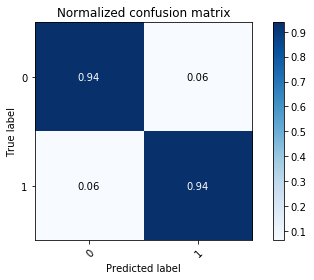

In [54]:
# Plot normalized confusion matrix
plot_confusion_matrix(np.argmax(class_test,axis=1), np.argmax(classes,axis=1), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [11]:
# Discuss batch normalization and its importance
# discuss drop out layers and its importance when talking about vgg6

### Convolutional Networks


Convolutional Neural Networks or
CNNs are networks designed to work with images or with any regularly
sampled dataset. CNNs reduce the complexity of the network by
requiring that neurons only respond to inputs from a subset of an
image (the receptive field). This mimics the operation of the visual
cortex where neurons only respond to a small part of the
field-of-view.

There are four principal components to a CNN:
- a convolutional layer,
- a non-linear activation function,
- a pooling or downsampling operation, and
- a fully connected layer for classification.

Dependent on the complexity of the network or structure of the data,
these components can occur singularly or chained together in multiple
sequences. 

<img src="figures/fig_cnn_1.png">


**Convolution** in a CNN refers to the convolution  of the input data
$I(x,y)$ with a kernel $K(x,y)$ which will produce a feature map $F(x,y)$

\begin{equation}
F(x,y) = K(x,y) * I(x,y)  = \sum_{x_0} \sum_{y_0} I(x-x_0, y-y_0) K(x_0, y_0).
\end{equation}

The kernel only responds to pixels within its receptive field (i.e.,
the size of the kernel), reducing the computational complexity of the
resulting network. The kernels in the convolution are described by a
depth (the number of kernels, $K$ applied to the image), and a stride
(how many pixels a kernel shifts at each step in the convolution;
typically one).  Given an $N\times M$ image, the result of the
convolution step is to transform a single image into a data cube of
feature maps with a dimension $N \times M \times K$.

Once learned the kernels within the convolutional layer often appears
as physically intuitive operations on the images 
such as edge detection filters.


As with traditional neural networks, a non-linear activation function
is applied to the individual pixels in the resulting feature
maps. 


The **pooling** in the CNN downsamples or subsamples the feature maps. Pooling summarizes values within a region
of interest (e.g., a 2x2 pixel window). The summary can be the average
pixel value but more commonly the maximum pixel value is preserved
(Max Pooling) in the downsampling. This pooling of the feature maps
reduces the size of the resulting network and makes the network less
sensitive to small translations or distortions between images.



The final layer of a CNN is the classification layer which maps the
output of the CNN to a set of labels. This is typically a fully
connected layer where each output
of the final pooling layer connects to all neurons in the
classification layer. 


### Training the network



Training a neural network is conceptually simple. Given a labelled set
of data and a loss function, we need to optimize
the weights and biases within the network by minimizing the loss.  A solution for training large
networks
uses backpropagation to efficiently estimate the gradient of the loss
function with respect
to the weights and biases.

If the loss function can be expressed in terms of a sum
over subsets of the training data (e.g., as is the case for the
L2 norm) the training can be undertaken either for the dataset as a
whole, for subsets of the data (batch learning), or for individual
entries (on-line or stochastic learning).


### CNNs: Increasing the complexity of the architecture with VGG6

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

import numpy as np
def vgg6(input_shape=(21, 21, 1), n_classes: int = 2):
    """
        VGG6
    :param input_shape:
    :param n_classes:
    :return:
    """

    model = tf.keras.models.Sequential(name='VGG6')
    # input: 21x21 images with 1 channel -> (21, 21, 1) tensors.
    # this applies 16 convolution filters of size 3x3 each.
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape, name='conv1'))
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', name='conv2'))
    model.add(tf.keras.layers.BatchNormalization(axis = 3, name = 'bn_1'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv3'))
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv4'))
    model.add(tf.keras.layers.BatchNormalization(axis = 3, name = 'bn_2'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(4, 4)))
    model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(256, activation='relu', name='fc_1'))
    model.add(tf.keras.layers.Dropout(0.5))
    # output layer
    activation = 'sigmoid' if n_classes == 1 else 'softmax'
    model.add(tf.keras.layers.Dense(n_classes, activation=activation, name='fc_out'))

    return model

In [16]:
#explain input shapes and why it is needed/important
#view a kernel filter - look for this
#explain dropouts
#why multiple batch normalization
# does the variation in the loss for the validation set tell me about the uncertainty in the classifier

In [28]:
vgg_model = vgg6()
vgg_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
n_epochs=200
vgg_model.summary()
vgg_model_history = vgg_model.fit(data_train, class_train, epochs=n_epochs, batch_size=512, verbose=2, 
                                  validation_data=(data_val, class_val), shuffle=True)

Model: "VGG6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 19, 19, 16)        160       
_________________________________________________________________
conv2 (Conv2D)               (None, 17, 17, 16)        2320      
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 17, 17, 16)        64        
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 8, 8, 16)          0         
_________________________________________________________________
conv3 (Conv2D)               (None, 6, 6, 32)          4640      
_________________________________________________________________
conv4 (Conv2D)               (None, 4, 4, 32)          9248   

Epoch 58/200
42000/42000 - 1s - loss: 0.0883 - accuracy: 0.9684 - val_loss: 0.1003 - val_accuracy: 0.9631
Epoch 59/200
42000/42000 - 1s - loss: 0.0916 - accuracy: 0.9680 - val_loss: 0.1500 - val_accuracy: 0.9411
Epoch 60/200
42000/42000 - 1s - loss: 0.0857 - accuracy: 0.9699 - val_loss: 0.1071 - val_accuracy: 0.9555
Epoch 61/200
42000/42000 - 1s - loss: 0.0864 - accuracy: 0.9692 - val_loss: 0.1651 - val_accuracy: 0.9364
Epoch 62/200
42000/42000 - 1s - loss: 0.0896 - accuracy: 0.9679 - val_loss: 0.5796 - val_accuracy: 0.8299
Epoch 63/200
42000/42000 - 1s - loss: 0.0855 - accuracy: 0.9695 - val_loss: 0.5580 - val_accuracy: 0.7150
Epoch 64/200
42000/42000 - 1s - loss: 0.1007 - accuracy: 0.9650 - val_loss: 0.4025 - val_accuracy: 0.8923
Epoch 65/200
42000/42000 - 1s - loss: 0.0858 - accuracy: 0.9695 - val_loss: 0.0497 - val_accuracy: 0.9819
Epoch 66/200
42000/42000 - 1s - loss: 0.0850 - accuracy: 0.9697 - val_loss: 0.0490 - val_accuracy: 0.9839
Epoch 67/200
42000/42000 - 1s - loss: 0.0801 -

Epoch 135/200
42000/42000 - 1s - loss: 0.0509 - accuracy: 0.9828 - val_loss: 1.0127 - val_accuracy: 0.8621
Epoch 136/200
42000/42000 - 1s - loss: 0.0467 - accuracy: 0.9846 - val_loss: 0.2760 - val_accuracy: 0.8962
Epoch 137/200
42000/42000 - 1s - loss: 0.0465 - accuracy: 0.9840 - val_loss: 0.0202 - val_accuracy: 0.9930
Epoch 138/200
42000/42000 - 1s - loss: 0.0442 - accuracy: 0.9846 - val_loss: 0.0200 - val_accuracy: 0.9936
Epoch 139/200
42000/42000 - 1s - loss: 0.0442 - accuracy: 0.9849 - val_loss: 0.0193 - val_accuracy: 0.9942
Epoch 140/200
42000/42000 - 1s - loss: 0.0448 - accuracy: 0.9846 - val_loss: 0.0215 - val_accuracy: 0.9924
Epoch 141/200
42000/42000 - 1s - loss: 0.0428 - accuracy: 0.9856 - val_loss: 0.0226 - val_accuracy: 0.9918
Epoch 142/200
42000/42000 - 1s - loss: 0.0452 - accuracy: 0.9845 - val_loss: 0.0305 - val_accuracy: 0.9893
Epoch 143/200
42000/42000 - 1s - loss: 0.0445 - accuracy: 0.9849 - val_loss: 0.0412 - val_accuracy: 0.9856
Epoch 144/200
42000/42000 - 1s - loss

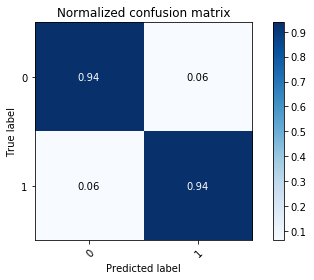

In [55]:
plot_confusion_matrix(np.argmax(class_test,axis=1), np.argmax(classes,axis=1), normalize=True,
                      title='Normalized confusion matrix')

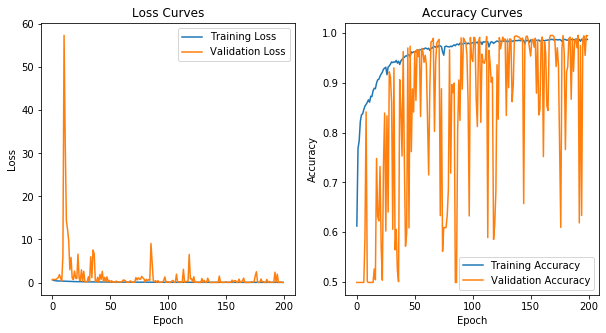

In [56]:
plot_model_history(vgg_model.history)

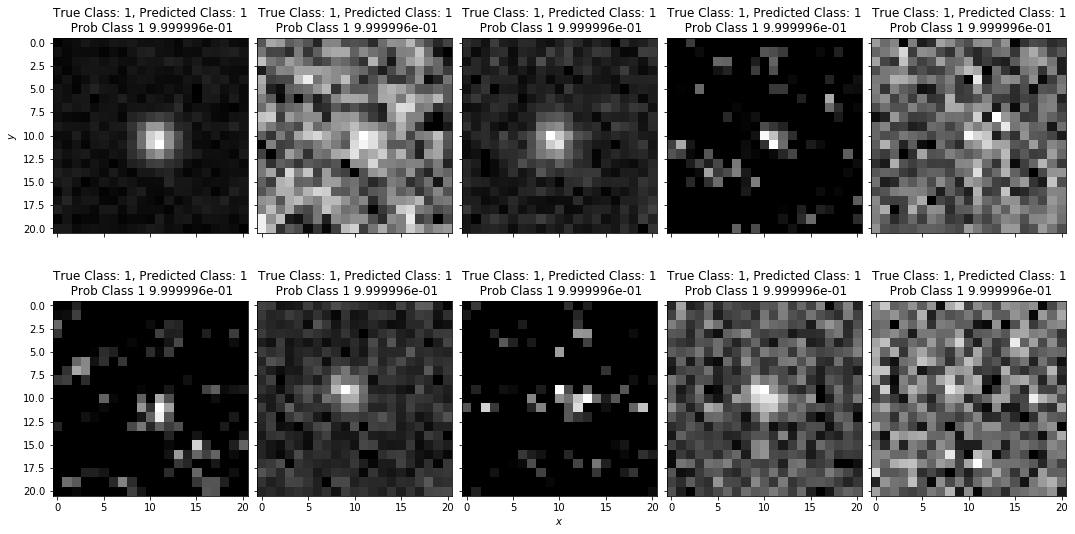

In [105]:
failures = classes[:,1] != class_test[:,1]
plot_image_array(data_test[failures], figsize=[16,10], subtitle='True Class: %i, Predicted Class: %i\n  Prob Class 1 %e ' % 
              (np.argmax(class_test[failures][i]), np.argmax(classes[failures][i]), classes[failures][i,1]))

### Interpreting networks: how many layers and how many neurons?

The number of layers, number of neurons in a layer, and the
connectivity of these layers is typically described as the network
architecture.  


Approaches to defining a network
architecture become more trial and error than applying an underlying
set of principles. For a starting point, however, there are relatively
few problems that benefit significantly from more than two layers and
we recommend starting with a single layer when training an initial
network and using cross-validation to determine when additional layers
lead result in the data being overfit.

As with the number of layers, the number of neurons within a layer
drives the computational cost (and requiring progressively larger
training sets to avoid overfitting of the data). There are many
proposals for rules of thumb for defining a network architecture:
- the number of neurons should lie between the number of inputs and output nodes
- the number of neurons should be equal to the number of outputs plus 2/3rd the number input nodes.
- the number of neurons in the hidden layer should be less than twice the size of the input layers


In [ ]:
#occlusion maps

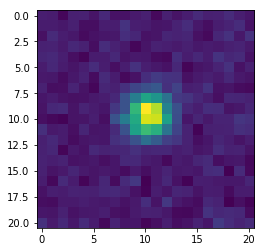

In [33]:
plt.imshow(data_test[11].reshape(21,21))

### Occulsion Maps

289


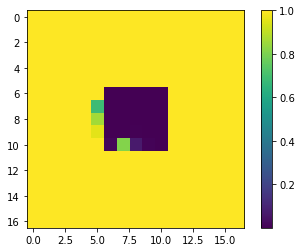

In [45]:
model = vgg_model
kernel_size=5
input_stamp = data_test[11].reshape(21,21)
i = 0
j=0
heatmap = []
keras_stamps = []
for j in range(22-kernel_size):
    for i in range(22-kernel_size):
        img = np.copy(input_stamp)
        img[i:i+kernel_size,j:j+kernel_size] = 0
        img = normalize_image(img)
        keras_stamps.append(img)
keras_stamps = np.array(keras_stamps).reshape([-1,21,21,1])
probs = model.predict(keras_stamps)
heatmap = probs[:,1]
plt.imshow(np.array(heatmap).reshape(22-kernel_size,22-kernel_size))
plt.colorbar()

### More complicated architectures: resnet50

In [ ]:
# Based on https://github.com/priya-dwivedi/Deep-Learning/blob/master/resnet_keras/Residual_Networks_yourself.ipynb
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
K.set_image_data_format('channels_last')
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

def ResNet50(input_shape=(21, 21, 1), classes=2):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    #X = AveragePooling2D((2,2), name="avg_pool")(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [ ]:
resnet50_model = ResNet50()
resnet50_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
n_epochs=5
resnet_model_history = resnet50_model.fit(data_train, class_train, epochs=n_epochs, batch_size=256, verbose=1, 
                                          validation_data=(data_val, class_val), shuffle=True)